In [1]:
pwd

u'/home/riddhisw/Documents/2017/Mar2017/Kalman_Test_Cases/2_Portable_Code/Scripts_Git'

In [2]:
import detailed_kf_bugtesting as bugdkf
import detailed_kf as dkf
import kf_fast as kffast

from ML_Kalman import Kalman

In [3]:
figname = 'Debug_KF_same_associativity_opt'
associativity = '(AB)C'

In [4]:
import numpy as np

########################
# File Data
########################
filename0_ = 'buggy'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 2
num_randparams_ = 10
space_size_ = np.arange(-8,3)
truncation_ =20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 48
n_testbefore_ = 49
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters
########################
apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 10.0
p_ = -1 #1 #-2 #-1 #0.0
J_ = 2
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.001
optimal_R_ = 0.001
b_delta_ = 0.5 

max_it_ = 5

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


In [5]:
from ML_Kalman import Kalman

Test_Object = Kalman(filename0_, savetopath_, max_it_,
                     exp_params_, kalman_params_, msmt_noise_params_,
                     true_noise_params_, user_defined_variance=None, 
                     skip_msmts=skip)

In [6]:
truth, signal = Test_Object.generate_data_from_truth(None)

In [7]:
pred_skf = kffast.kf_2017(signal, n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, x0_, p0_, 
                          optimal_sigma_, optimal_R_, Test_Object.basisA, 
                          phase_correction=0 ,prediction_method="PropForward", skip_msmts=1, 
                          descriptor='Fast_KF')

pred_skf2 = kffast.kf_2017(signal, n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, x0_, p0_, 
                          optimal_sigma_, optimal_R_, Test_Object.basisA, 
                          phase_correction=0 ,prediction_method="ZeroGain", skip_msmts=1, 
                          descriptor='Fast_KF_II')

pred_bugdkf, amps_bugdkf = bugdkf.detailed_kf("Debugging_KF", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

pred_bugdkf2, amps_bugdkf2 = bugdkf.detailed_kf("Debugging_KF_II", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

pred_dkf, amps_dkf = dkf.detailed_kf("Detailed_KF", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

Fast_KF
1
Fast_KF_II
0


In [8]:
bug_dkf_object = np.load('Debugging_KF.npz')

bug_dkf_object2 = np.load('Debugging_KF_II.npz')

dkf_data_object = np.load('Detailed_KF.npz')

skf_data_object = np.load('Fast_KF.npz')

skf_data_object2 = np.load('Fast_KF_II.npz')

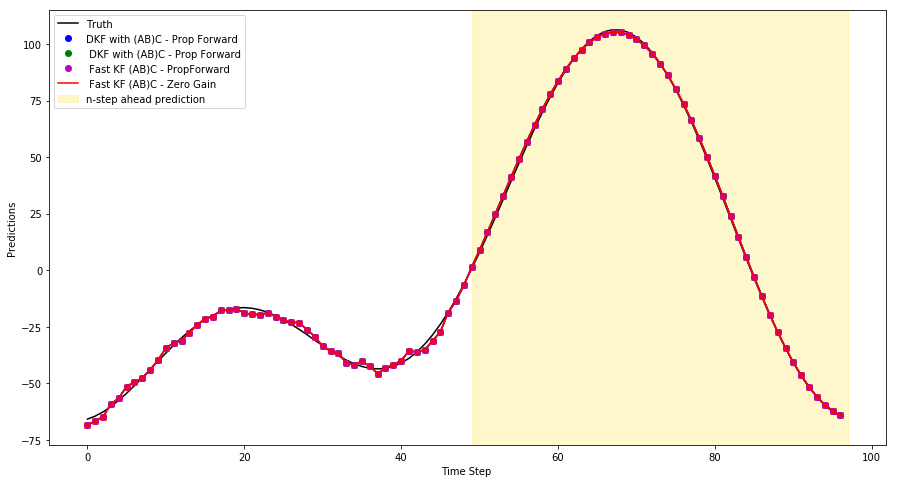

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
i=0
item = 'x_hat'
plt.xlabel('Time Step ')
plt.ylabel('Predictions')

plt.plot(truth[n_train_ - n_testbefore_: n_train_ + n_predict_], 'k', label='Truth')

plt.plot(pred_bugdkf,'bo' , label='DKF with %s - Prop Forward'%(associativity))
plt.plot(pred_dkf, 'go', label=' DKF with (AB)C - Prop Forward')

plt.plot(bug_dkf_object['predictions'], 'b')
plt.plot(dkf_data_object['predictions'], 'g')

#plt.plot(pred_bugdkf2,'c' , label='Another Trial of DKF %s'%(associativity))
#plt.plot(bug_dkf_object2['predictions'], 'cx')

plt.plot(pred_skf, 'mo', label=' Fast KF %s - PropForward'%(associativity))
plt.plot(skf_data_object['predictions'], 'm')

plt.plot(pred_skf2, 'r', label=' Fast KF %s - Zero Gain'%(associativity))
plt.plot(skf_data_object2['predictions'], 'rx')

plt.axvspan(n_testbefore_,n_testbefore_+n_predict_, ymin=0, ymax=1, color='gold', alpha=0.2, label='n-step ahead prediction ')
plt.legend(loc=2)

plt.savefig(figname+'_Predictions', format="svg")
plt.show()

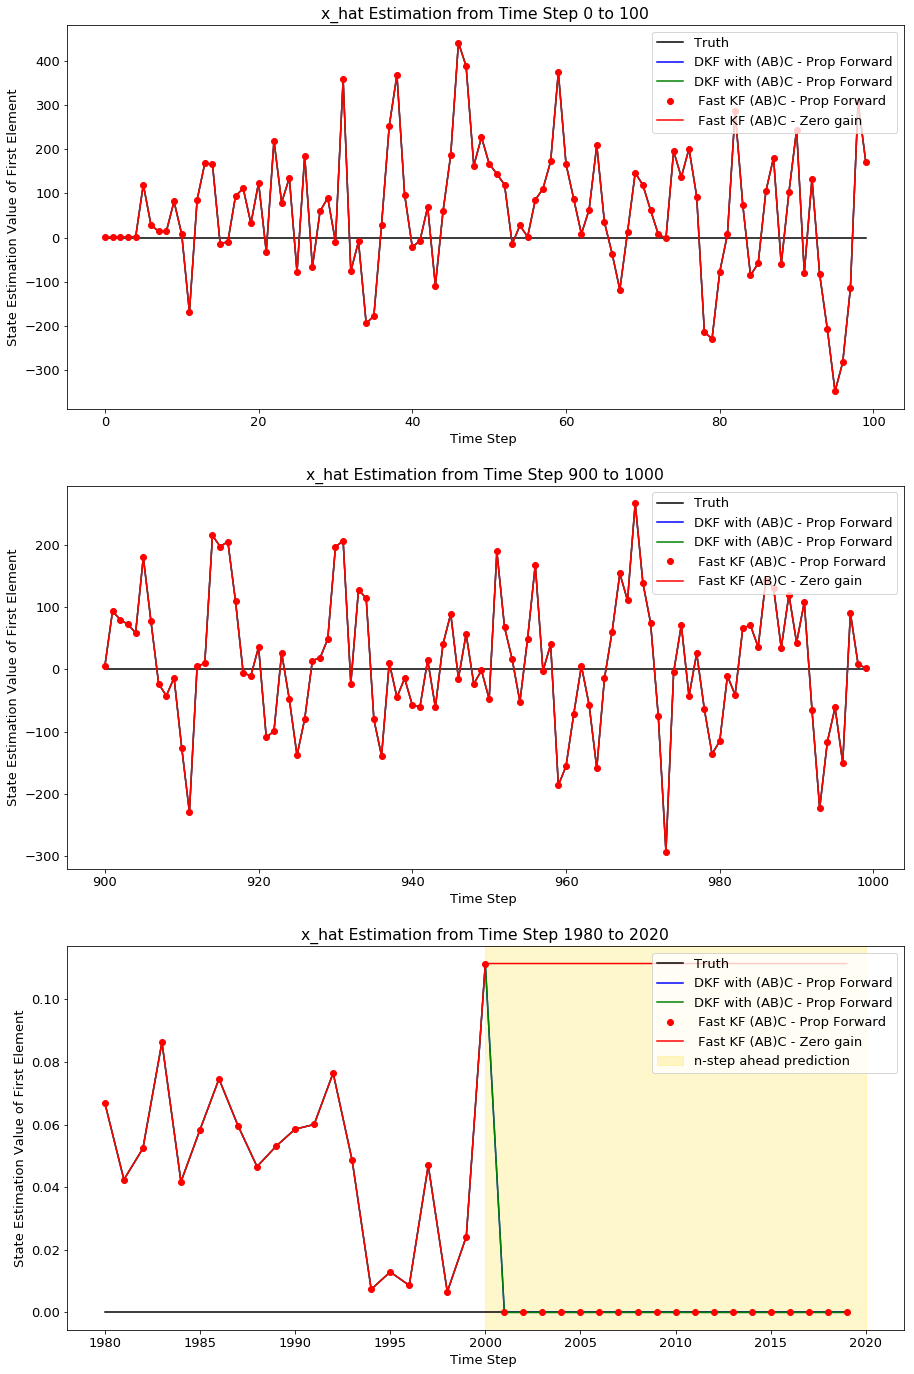

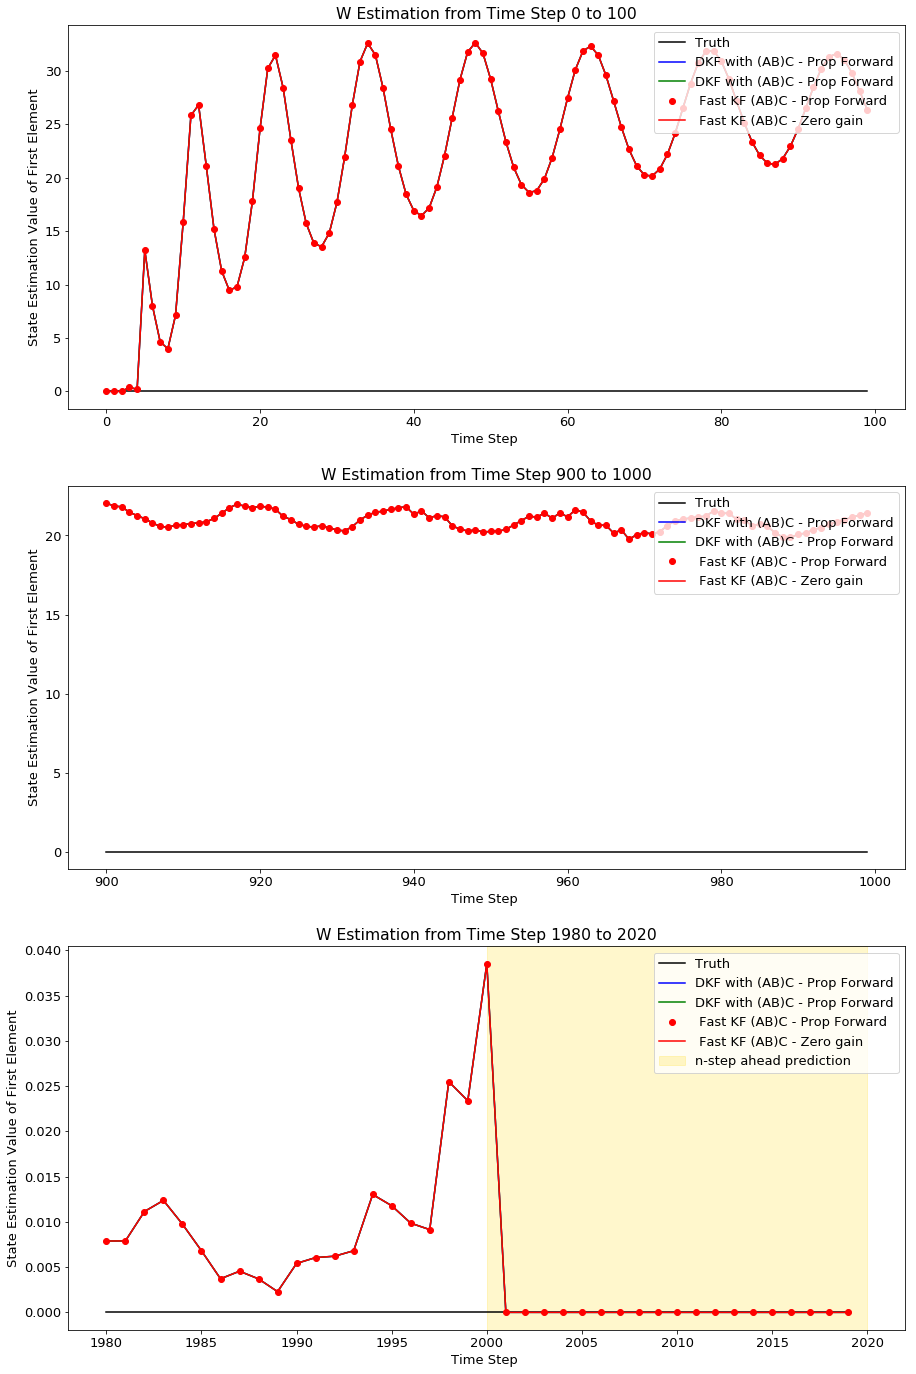

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size']= 13

item_list = ['x_hat', 'W']
time_start = [0, 900, 1980]
time_end = [100, 1000, 2020]
i=0
for idx_k in xrange(2):
    plt.figure(figsize=(15,24))
    for i in xrange(3):
        item = item_list[idx_k]
        plt.subplot(3,1,i+1)
        plt.title('%s Estimation from Time Step %s to %s' %(item, time_start[i], time_end[i]))
        plt.xlabel('Time Step ')
        plt.ylabel('State Estimation Value of First Element')
        plt.plot(range(time_start[i], time_end[i], 1), np.zeros(time_end[i] - time_start[i]), 'k', label='Truth')
        plt.plot(range(time_start[i], time_end[i], 1), bug_dkf_object[item][0,0,time_start[i]:time_end[i]],'b' , label='DKF with %s - Prop Forward' %(associativity))
        #plt.plot(range(time_start[i], time_end[i], 1), bug_dkf_object2[item][0,0,time_start[i]:time_end[i]],'b' , label='Another trial of DKF A(BC)')
        plt.plot(range(time_start[i], time_end[i], 1), dkf_data_object[item][0,0,time_start[i]:time_end[i]], 'g' , label='DKF with (AB)C - Prop Forward')
        plt.plot(range(time_start[i], time_end[i], 1), skf_data_object[item][0,0,time_start[i]:time_end[i]], 'ro', label=' Fast KF %s - Prop Forward'%(associativity))
        plt.plot(range(time_start[i], time_end[i], 1), skf_data_object2[item][0,0,time_start[i]:time_end[i]], 'r', label=' Fast KF %s - Zero gain'%(associativity)) 
        if i==2:
            plt.axvspan(n_train_, time_end[i], ymin=0, ymax=1, color='gold', alpha=0.2, label='n-step ahead prediction ')
        plt.legend(loc=1)
    plt.savefig(figname+item, format="svg")
    plt.show()

The bug testing version of the DKF confirms that the following are not the causes for disparity (individually added and tested):
    - Calc_Gamma is not the cause of the disparity
    - Change "twonumf = numf*2" to "twonumf = int(numf*2)"
    - Convert n_converge to n_train in the entire code
    - Changing S_inv to 1.0/S
    - Changing from math.cos to np.cos
    - Optimising using numba
    
The following change has an impact:
    - Changing np.dot(np.dot()) instance to numpy.linalg.multi_dot()
    

In [11]:
figname+item

'Debug_KF_same_associativity_optW'

In [12]:
#### Create collated SVG figure
import svgutils.transform as sg
import sys 

'''
Filname for compiled image:  'compiled'
'''
#create new SVG figure
fig = sg.SVGFigure("15cm", "24cm")

figureimp = sg.fromfile(figname+item)
figimp = figureimp.getroot()
figimp.moveto(10,0,scale=0.49)
fig.append(figimp)
fig.save("compiled.svg")

# Export as pdf using Shell
!echo $SHELL
!pwd
!inkscape --export-pdf=FIG_Kalman_DKF_with_Different_Associativity_Predictions.pdf compiled.svg
!exit

/bin/bash
/home/riddhisw/Documents/2017/Mar2017/Kalman_Test_Cases/2_Portable_Code/Scripts_Git
